In [1]:
from numpy import random
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal, ks_2samp

mean = np.array([-5, 5])
cov = 5 * np.eye(2)

x = np.linspace(-15, 15, 100)  
y = np.linspace(-15, 15, 100)

X, Y = np.meshgrid(x, y)


Calculating the Score Function: Larger values indicate regions where small changes in 
x lead to large changes in probability.

In [2]:
def score_function(mean, variance, x): # check this 
    mean = mean.reshape(-1, 1) if mean.ndim == 1 else mean
    return -(x - mean) / variance

In [3]:
def draw_guassian_dist(X, Y, Z):
    plt.figure(figsize=(8, 6))
    plt.contourf(X, Y, Z, levels=20, cmap='viridis')
    plt.colorbar(label='Probability Density')
    plt.title('2D Gaussian Distribution')
    plt.show()

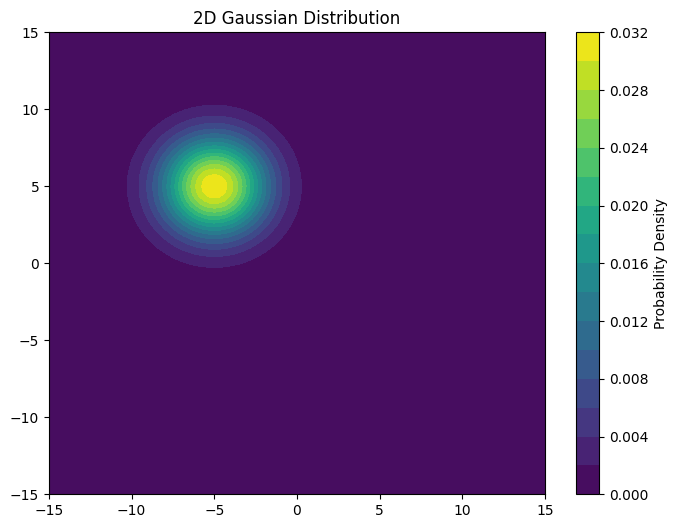

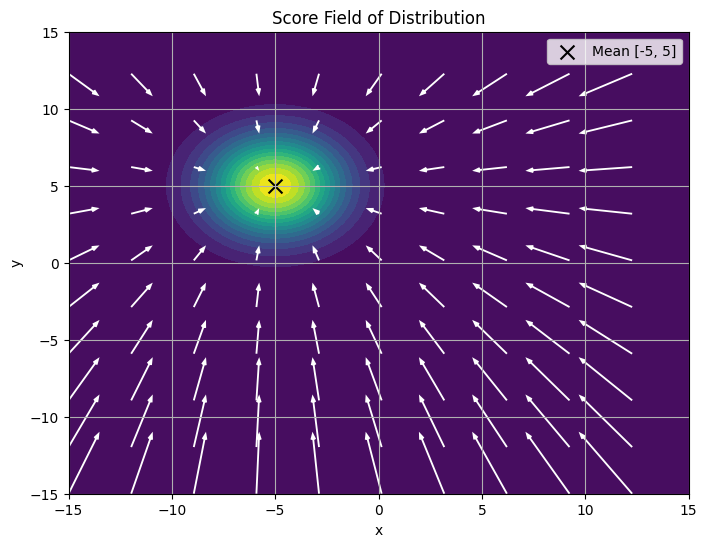

In [4]:
def gen_quiver_plot(X, Y, Z):
    step = 10
    X_sub = X[::step, ::step]
    Y_sub = Y[::step, ::step]
    
    points_arr = np.vstack([X_sub.ravel(), Y_sub.ravel()])
    
    variance = 5
    scores = score_function(mean, variance, points_arr)
    i = scores[0].reshape(X_sub.shape)
    j = scores[1].reshape(Y_sub.shape)
    
    plt.figure(figsize = (8, 6))
    
    plt.contourf(X, Y, Z, levels = 20, cmap = 'viridis')
    plt.quiver(X_sub, Y_sub, i, j,
               color = 'white', scale = 40, width = 0.003, 
               headwidth = 3, headlength = 4)
    plt.scatter(mean[0], mean[1], c = 'black', s = 100, label = 'Mean [-5, 5]', marker = 'x')
    plt.xlim(-15, 15)
    plt.ylim(-15, 15)
    plt.title("Score Field of Distribution")
    plt.xlabel('x')
    plt.ylabel('y')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    
pos = np.dstack((X, Y))
rv = multivariate_normal(mean, cov)
Z = rv.pdf(pos)

draw_guassian_dist(X, Y, Z)
gen_quiver_plot(X, Y, Z)

In [5]:
def plot_trajectories(trajectories, X, Y, Z):
    plt.figure(figsize = (8, 6))
    plt.contourf(X, Y, Z, cmap = 'viridis', levels = 20, alpha = 0.3)
    
    for i in range(min(20, trajectories.shape[1])):
        plt.plot(trajectories[:, i, 0], trajectories[:, i, 1], 
                'r-', alpha = 0.5, lw = 0.5, solid_capstyle = 'round')
    
    
    plt.scatter(trajectories[0, :20, 0], trajectories[0, :20, 1], 
               c = 'blue', s = 20, label = 'Initial Points')
    plt.scatter(trajectories[-1, :20, 0], trajectories[-1, :20, 1], 
               c = 'red', s = 20, label = 'Final Samples')
    
    plt.scatter(mean[0], mean[1], c = 'black', s = 100, marker = '*', 
                label = 'Mean', edgecolor = 'white')
    plt.title('Sampling Trajectories')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.legend()
    plt.grid(True)
    plt.xlim(-15, 15)
    plt.ylim(-15, 15)
    plt.show()



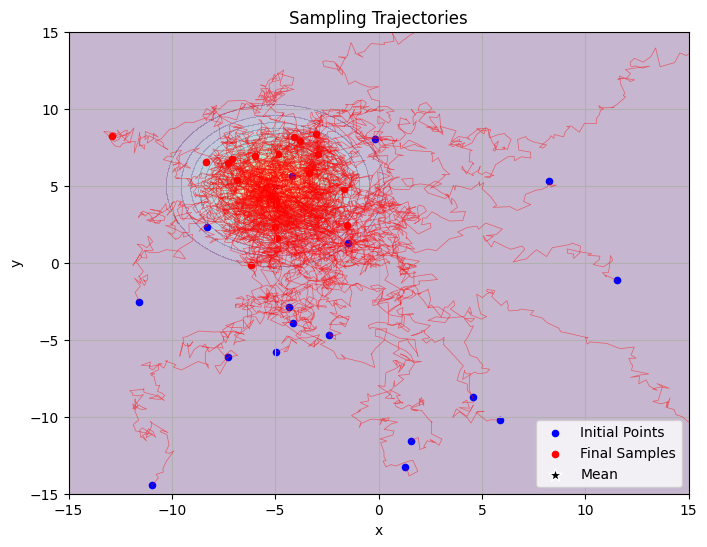

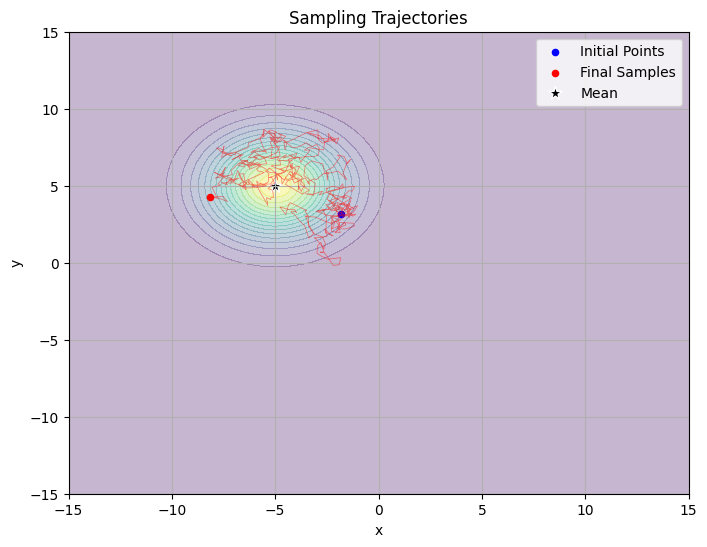

In [6]:
def langevin_sampling(initial_points, num_iters = 1000, learning_rate = 0.01):
    samples = initial_points.copy()
    trajectory = [samples.copy()]
    
    for _ in range(num_iters):
        scores = score_function(mean, 5, samples.T, )
        scores = scores.T
        
        noise = np.random.randn(*samples.shape)
        samples = samples + learning_rate * scores + np.sqrt(learning_rate * 2) * noise
        trajectory.append(samples.copy())
        
    return samples, np.array(trajectory)

initial_points = random.randn(100, 2) * 10
final_samples, trajectories = langevin_sampling(
    initial_points,
    num_iters = 500,
    learning_rate = 0.05
    )  
  
plot_trajectories(trajectories, X, Y, Z)

# Plot only a single trajectory
initial_point = np.random.randn(1, 2) * 10
final_sample, trajectory = langevin_sampling(
    initial_point,
    num_iters=500,
    learning_rate=0.05
)   
plot_trajectories(trajectory, X, Y, Z)

In [7]:
def choose_samples_with_function():
    mean = np.array([-5, 5])
    cov = 5 * np.eye(2)
    samples = np.random.multivariate_normal(mean, cov, size = 1000)
    return samples

In [8]:
def compare_langevin_mv(mv_samples, ld_samples):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
    ax1.scatter(mv_samples[:, 0], mv_samples[:, 1], alpha=0.5)
    ax1.set_title('Samples from Numpy')
    ax2.scatter(ld_samples[:, 0], ld_samples[:, 1], alpha=0.5)
    ax2.set_title('Langevin Dynamics')
    
    for ax in (ax1, ax2):
        ax.scatter(-5, 5, c='red', marker='x', s=100)
        ax.set_xlim(-15, 5)
        ax.set_ylim(-5, 15)
        ax.grid(True, alpha=0.3)
        ax.set_xlabel('x₁')
        ax.set_ylabel('x₂')
    
    plt.tight_layout()
    plt.show()

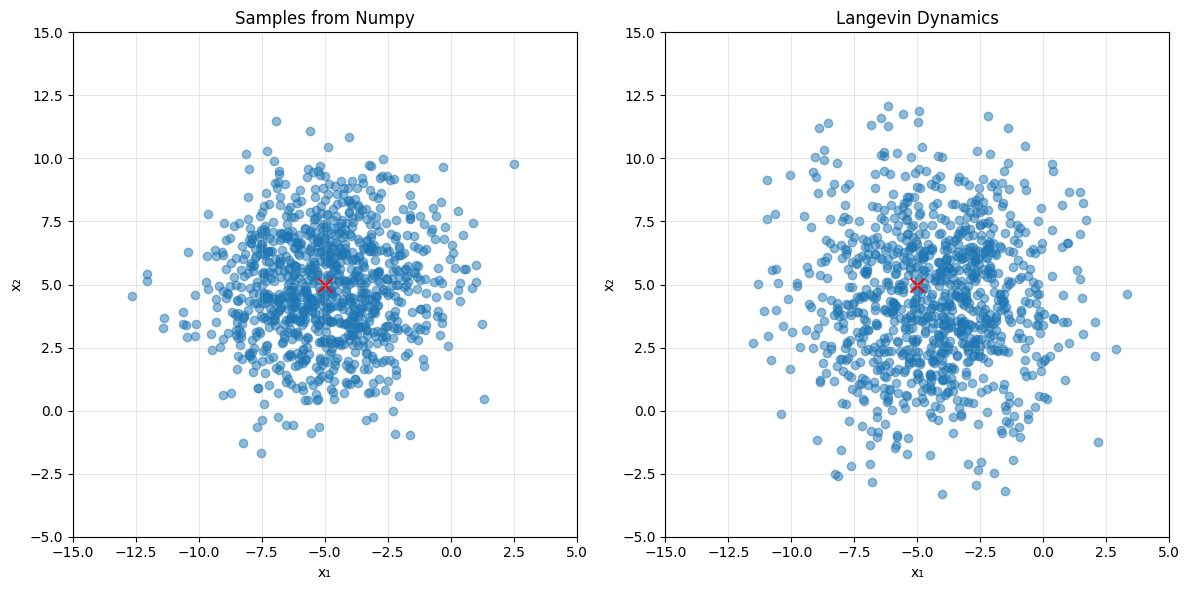

In [9]:
mv_samples = mv_samples = choose_samples_with_function()
ld_samples, _ = langevin_sampling(np.random.randn(1000, 2)*10)
compare_langevin_mv(mv_samples, ld_samples)

In [10]:
def compare_mean(mv_samples, ld_samples):
    mv_mean = np.mean(mv_samples, axis = 0)
    ld_mean = np.mean(ld_samples, axis = 0)
    return mv_mean, ld_mean

In [11]:
def compare_cov(mv_samples, ld_samples):
    mv_cov = np.cov(mv_samples.T)
    ld_cov = np.cov(ld_samples.T)
    return mv_cov, ld_cov
    

In [12]:
def compare_metrics():
    mv_mean, ld_mean = compare_mean(mv_samples, ld_samples)
    mv_cov, ld_cov = compare_cov(mv_samples, ld_samples)
    stats_data = [
        ["Mean (x₁, x₂)", f"{mv_mean.round(2)}", f"{ld_mean.round(2)}"],
        ["Covariance (diag)", f"{mv_cov.diagonal().round(2)}", f"{ld_cov.diagonal().round(2)}"],
        ["KS Test p-value (x₁)", "-", f"{ks_2samp(mv_samples[:,0], ld_samples[:,0]).pvalue:.15f}"], 
        ["KS Test p-value (x₂)", "-", f"{ks_2samp(mv_samples[:,1], ld_samples[:,1]).pvalue:.15f}"]
    ]
    
    for stat in stats_data:
        print(stat)
    
compare_metrics()

['Mean (x₁, x₂)', '[-4.99  4.89]', '[-4.37  4.37]']
['Covariance (diag)', '[5.2  4.83]', '[6.46 7.64]']
['KS Test p-value (x₁)', '-', '0.000000023215972']
['KS Test p-value (x₂)', '-', '0.000000087970891']


## Bonus Question: Sampling from a Two-Component Gaussian Mixture

**Answer**: Yes, in principle you *can* sample properly from a two-component Gaussian mixture using Langevin dynamics, because all that Langevin dynamics requires is access to $\nabla_x \log p(x)$. For the mixture $p(x) \;=\; \alpha\, \mathcal{N}(x;\,\mu_1,\Sigma_1)\;+\;(1-\alpha)\,\mathcal{N}(x;\,\mu_2,\Sigma_2)$, you can write down a closed-form expression for $\nabla_x \log p(x) \;=\; \nabla_x \log \Bigl[\alpha\,\mathcal{N}(x;\,\mu_1,\Sigma_1) \;+\; (1-\alpha)\,\mathcal{N}(x;\,\mu_2,\Sigma_2)\Bigr]$ by using the sum of weighted Gaussians in the numerator and normalizing by $p(x)$. As long as you can compute this gradient, you can plug it into the Langevin update step $x_{\text{new}} \;=\; x_{\text{old}} \;+\; \epsilon\,\nabla_x \log p(x_{\text{old}}) \;+\; \sqrt{2\,\epsilon}\,\eta,\quad \eta \sim \mathcal{N}(0, I)$.

However, **the main caveat** when using plain Langevin dynamics on a *multi-modal* distribution (like a well-separated mixture) is that it can get "trapped" in one mode for a long time. This does not invalidate the method mathematically—over an infinitely long run, Langevin dynamics *is* an MCMC method that will explore all modes eventually. But in practice, if $\Sigma_1$ and $\Sigma_2$ are small and the modes $\mu_1, \mu_2$ are far apart, a single chain may take a very long time to traverse from one component to the other.

Despite that, for most practical uses—especially if the modes are not extremely far apart—Langevin dynamics *will* let you sample from both Gaussian components eventually. Below is a code to demonstrate that. 

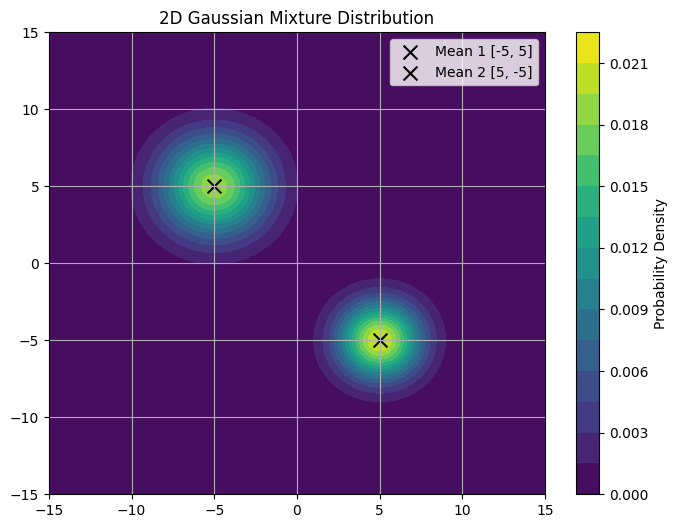

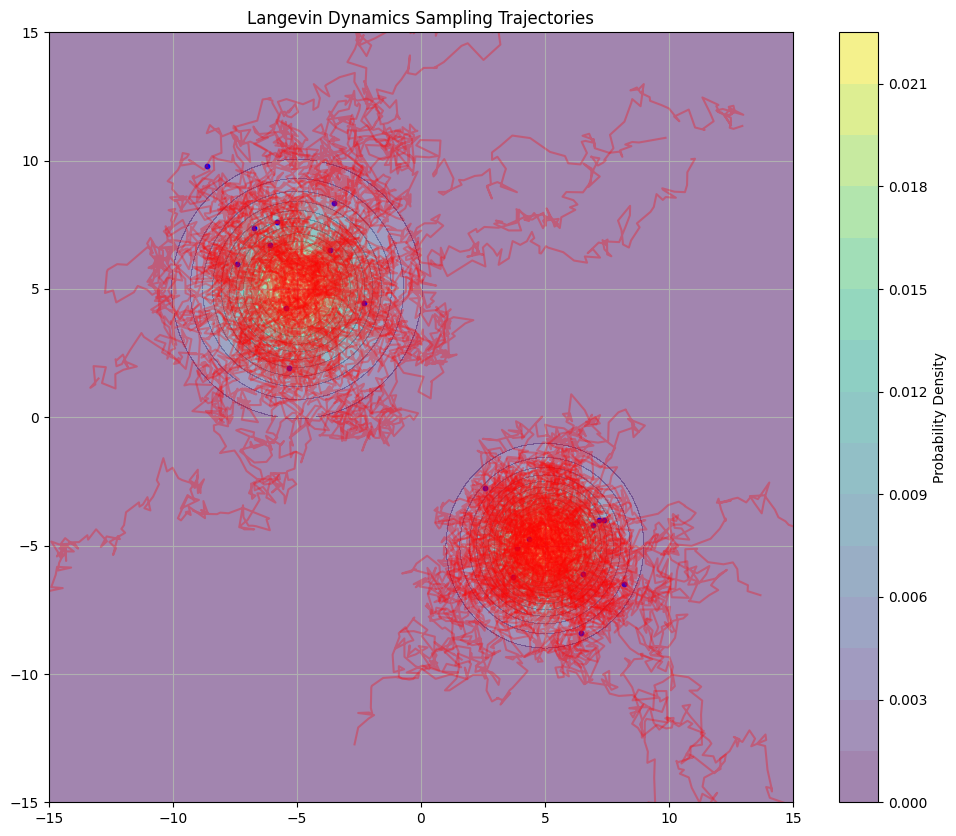

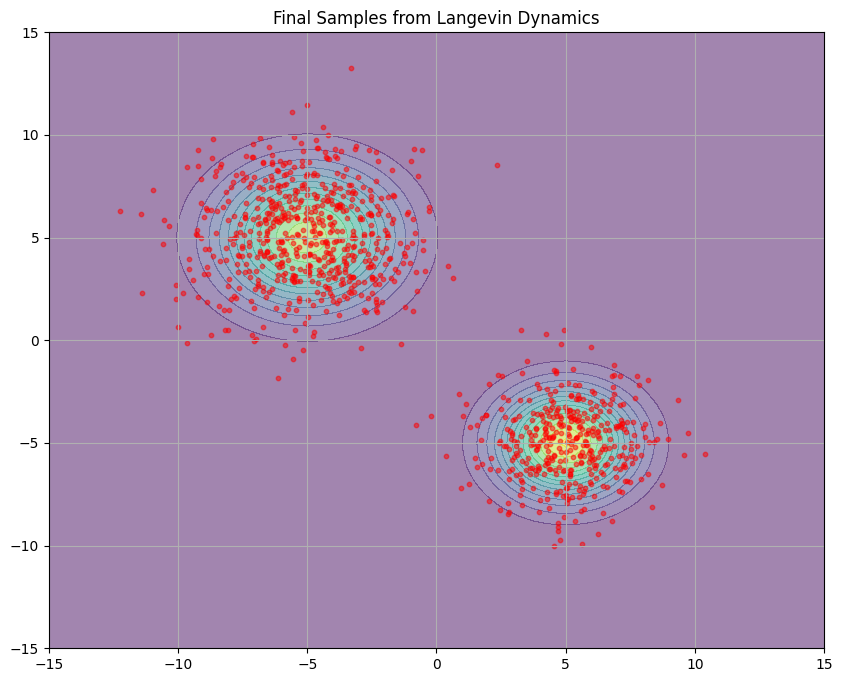

In [13]:
def mixture_score_function(x, means, covs, weights):
    d = x.shape[0]
    n = x.shape[1]
    score = np.zeros_like(x)
    denominator = 0
    for i in range(len(means)):
        mean = means[i].reshape(-1, 1)
        cov = covs[i]
        precision = np.linalg.inv(cov)
        diff = x - mean
        exponent = -0.5 * np.sum(diff * (precision @ diff), axis=0)
        coef = weights[i] / np.sqrt((2 * np.pi) ** d * np.linalg.det(cov))
        pdf_component = coef * np.exp(exponent)
        denominator += pdf_component
    for i in range(len(means)):
        mean = means[i].reshape(-1, 1)
        cov = covs[i]
        precision = np.linalg.inv(cov)
        diff = x - mean
        exponent = -0.5 * np.sum(diff * (precision @ diff), axis=0)
        coef = weights[i] / np.sqrt((2 * np.pi) ** d * np.linalg.det(cov))
        pdf_component = coef * np.exp(exponent)
        component_score = -precision @ diff
        score += (pdf_component / denominator) * component_score
    return score

def langevin_sampling_mixture(initial_points, means, covs, weights, num_iters=1000, learning_rate=0.01):
    samples = initial_points.copy()
    trajectory = [samples.copy()]
    for _ in range(num_iters):
        scores = mixture_score_function(samples.T, means, covs, weights)
        scores = scores.T
        noise = np.random.randn(*samples.shape)
        samples = samples + learning_rate * scores + np.sqrt(learning_rate * 2) * noise
        trajectory.append(samples.copy())
    return samples, np.array(trajectory)

def plot_mixture_density(means, covs, weights, X, Y):
    pos = np.dstack((X, Y))
    Z = np.zeros_like(X)
    for i in range(len(means)):
        rv = multivariate_normal(means[i], covs[i])
        Z += weights[i] * rv.pdf(pos)
    plt.figure(figsize=(8, 6))
    plt.contourf(X, Y, Z, levels=20, cmap='viridis')
    plt.colorbar(label='Probability Density')
    plt.title('2D Gaussian Mixture Distribution')
    for i, mean in enumerate(means):
        plt.scatter(mean[0], mean[1], c='black', s=100, marker='x', 
                    label=f'Mean {i+1} [{mean[0]}, {mean[1]}]')
    plt.xlim(-15, 15)
    plt.ylim(-15, 15)
    plt.legend()
    plt.grid(True)
    plt.show()
    return Z


means = [np.array([-5, 5]), np.array([5, -5])]
covs = [5 * np.eye(2), 3 * np.eye(2)]
weights = [0.6, 0.4]

x = np.linspace(-15, 15, 100)
y = np.linspace(-15, 15, 100)
X, Y = np.meshgrid(x, y)

Z = plot_mixture_density(means, covs, weights, X, Y)

initial_points = np.random.randn(1000, 2) * 10

mixture_samples, mixture_trajectories = langevin_sampling_mixture(
    initial_points,
    means,
    covs,
    weights,
    num_iters=800, 
    learning_rate=0.05
)

def plot_trajectories(trajectories, X, Y, Z):
    plt.figure(figsize=(12, 10))
    plt.contourf(X, Y, Z, levels=20, cmap='viridis', alpha=0.5)
    plt.colorbar(label='Probability Density')
    plt.title('Langevin Dynamics Sampling Trajectories')
    
    for i in range(min(20, trajectories.shape[1])):
        plt.plot(trajectories[:, i, 0], trajectories[:, i, 1], 'r-', alpha=0.3)
        plt.scatter(trajectories[-1, i, 0], trajectories[-1, i, 1], c='blue', s=10)
    
    plt.xlim(-15, 15)
    plt.ylim(-15, 15)
    plt.grid(True)
    plt.show()

plot_trajectories(mixture_trajectories, X, Y, Z)

plt.figure(figsize=(10, 8))
plt.contourf(X, Y, Z, levels=20, cmap='viridis', alpha=0.5)
plt.scatter(mixture_samples[:, 0], mixture_samples[:, 1], c='red', s=10, alpha=0.5)
plt.title('Final Samples from Langevin Dynamics')
plt.xlim(-15, 15)
plt.ylim(-15, 15)
plt.grid(True)
plt.show()